# Few Shot Sampling of Blood Smear Images

## Custom Dataloader

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [2]:

def resize_and_pad(image, target_size=(320, 320), fill=0):
    """
    Resize an image to fit within the target size while preserving the aspect ratio,
    then pad the shorter sides with a constant value to reach the target size.

    Args:
        image (PIL.Image): Input image.
        target_size (tuple): Target size (width, height), default (224, 224).
        fill (int or tuple): Padding fill value (e.g., 0 for black, 255 for white).

    Returns:
        PIL.Image: Resized and padded image of size target_size.
    """
    # Get original dimensions
    width, height = image.size
    target_width, target_height = target_size

    # Calculate scaling factor to fit within target size
    scale = min(target_width / width, target_height / height)
    new_width = int(width * scale)
    new_height = int(height * scale)

    # Resize image with correct (height, width) order
    resized_image = transforms.functional.resize(image, (new_height, new_width))

    # Calculate padding to center the image
    padding_left = (target_width - new_width) // 2
    padding_top = (target_height - new_height) // 2
    # Ensure padding adds up exactly to the difference
    padding_right = target_width - new_width - padding_left
    padding_bottom = target_height - new_height - padding_top

    # Apply padding
    padded_image = transforms.functional.pad(
        resized_image,
        padding=(padding_left, padding_top, padding_right, padding_bottom),
        fill=fill
    )

    return padded_image

In [3]:
# Basic Image transformation
def get_base_transforms(target_size=(320, 320), use_grayscale=False):
    """
    Returns a composed set of basic image transformations for preprocessing input images.

    Parameters:
    - target_size (tuple): The desired output size (height, width) of the image after resizing and padding.
    - use_grayscale (bool): If True, converts the image to grayscale with 3 channels before applying other transformations.

    Returns:
    - torchvision.transforms.Compose: A sequence of transformations including:
        - Optional grayscale conversion with 3 output channels,
        - Resizing and padding the image to match the target size,
        - Conversion to tensor,
        - Normalization using ImageNet mean and standard deviation.
    """
    base_transforms = [
        transforms.Lambda(lambda img: resize_and_pad(img, target_size=target_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]

    if use_grayscale:
        base_transforms.insert(0, transforms.Grayscale(num_output_channels=3))  # Keep 3 channels for compatibility
    return transforms.Compose(base_transforms)


# Data augmentation transforms
def get_augmentation_transforms():
    """
    Returns a composed set of data augmentation transformations to artificially expand the training dataset.

    This function applies a series of random transformations to simulate variations in brightness, contrast, orientation,
    and color mode, helping the model generalize better.

    Returns:
    - torchvision.transforms.Compose: A sequence of transformations including:
        - Random brightness and contrast adjustment (ColorJitter),
        - Random horizontal and vertical flipping,
        - Random rotation by up to ±10 degrees,
        - Random conversion to grayscale with a 20% probability.
    """
    return transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Simulate lighting/stain variations
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.RandomGrayscale(p=0.2)  # Optional: Randomly apply grayscale as part of augmentation
    ])


In [4]:
class FewShotDataset(Dataset):
    def __init__(self, data_dir, split, num_ways=5, num_support=5,
                 num_query=10, num_episodes=100, target_size=(320, 320),
                 use_grayscale=False,
                 augment=False,
                 ):
        """
        Args:
            data_dir (str): Path to dataset directory
            split (str): One of 'train', 'validation', or 'test'
            num_ways (int): Number of classes per episode
            num_support (int): Number of support samples per class (i.e. number of shots)
            num_query (int): Number of query samples per class
            num_episodes (int): Number of episodes per epoch
            use_grayscale(bool),  Use grayscale or not
            augment(bool),        For data augmentation technique
        """
        self.split_dir = os.path.join(data_dir, split)
        self.num_ways = num_ways
        self.num_support = num_support
        self.num_query = num_query
        self.num_episodes = num_episodes
        base_transform = get_base_transforms(target_size, use_grayscale)
        if augment:
            augmentation_transform = get_augmentation_transforms()
            self.transform = transforms.Compose([augmentation_transform, base_transform])
        else:
            self.transform = base_transform

        # Load class directories and their images
        self.classes = [c for c in os.listdir(self.split_dir)
                       if os.path.isdir(os.path.join(self.split_dir, c))]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}  # Map class names to indices
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}  # Map indices to class names
        self.class_images = {
            c: [os.path.join(self.split_dir, c, img)
                for img in os.listdir(os.path.join(self.split_dir, c))]
            for c in self.classes
        }

    def __len__(self):
        return self.num_episodes

    def __getitem__(self, index):
        # Randomly select N classes for this episode
        selected_classes = np.random.choice(self.classes, self.num_ways, replace=False)

        support_images = []
        support_labels = []
        query_images = []
        query_labels = []

        for label_idx, class_name in enumerate(selected_classes):
            all_images = self.class_images[class_name]
            if len(all_images) < self.num_support + self.num_query:
                raise ValueError(
                    f"Class {class_name} has only {len(all_images)} images. "
                    f"Need at least {self.num_support + self.num_query}."
                )

            # Randomly select support and query images
            selected_indices = np.random.choice(
                len(all_images),
                self.num_support + self.num_query,
                replace=False #True#########################################################################
            )
            support_paths = [all_images[i] for i in selected_indices[:self.num_support]]
            query_paths = [all_images[i] for i in selected_indices[self.num_support:]]

            # Load and transform support images
            for path in support_paths:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                support_images.append(img)
                support_labels.append(label_idx)

            # Load and transform query images
            for path in query_paths:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                query_images.append(img)
                query_labels.append(label_idx)

        # Shuffle the support and query sets
        support_indices = np.arange(len(support_images))
        query_indices = np.arange(len(query_images))
        np.random.shuffle(support_indices)
        np.random.shuffle(query_indices)

        support_images = [support_images[i] for i in support_indices]
        support_labels = [support_labels[i] for i in support_indices]
        query_images = [query_images[i] for i in query_indices]
        query_labels = [query_labels[i] for i in query_indices]

        # Convert lists to tensors
        support_set = (
            torch.stack(support_images),
            torch.tensor(support_labels, dtype=torch.long)
        )
        query_set = (
            torch.stack(query_images),
            torch.tensor(query_labels, dtype=torch.long)
        )
        # Store the selected class names for this episode
        selected_classes = [str(cls) for cls in selected_classes]
        episode_classes = selected_classes

        return support_set, query_set, episode_classes

In [5]:
def get_data_loader(dataset, batch_size=1, shuffle=True):
    """
    Returns DataLoader for the dataset.
    Note: Batch size should typically be 1 for few-shot learning,
    as each episode is a separate task.
    """
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True
    )

## Modelling

### Embedding Based

#### Mount Drive

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')
# Adjust data_dir based on your Drive structure
# data_dir = '/content/drive/MyDrive/Computer vision with few shot sampling focus group/data_set'
# output_dir = '/content/drive/MyDrive/Computer vision with few shot sampling focus group/protonet_results' # For saving models/plots

data_dir = "/home/ifihan/multi-dease-detection/data_set"
output_dir = "/home/ifihan/multi-dease-detection/results"  # For saving models/plots

In [7]:
import torch.nn as nn

def euclidean_distance(query_embeddings, prototype_embeddings):
    """
    Calculates the Euclidean distance between query embeddings and prototypes.
    Args:
        query_embeddings (Tensor): shape (num_query_total, embedding_dim)
        prototype_embeddings (Tensor): shape (num_ways, embedding_dim)
    Returns:
        distances (Tensor): shape (num_query_total, num_ways)
    """
    num_query_total = query_embeddings.size(0)
    num_ways = prototype_embeddings.size(0)
    # Expand dimensions for broadcasting:
    # query: (num_query_total, 1, embedding_dim)
    # proto: (1, num_ways, embedding_dim)
    distances = (query_embeddings.unsqueeze(1) - prototype_embeddings.unsqueeze(0)).pow(2).sum(dim=2)
    # Result shape: (num_query_total, num_ways)
    return distances

class PrototypicalNetwork(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder (nn.Module): The feature extractor network.
        """
        super().__init__()
        self.encoder = encoder

    def calculate_prototypes(self, support_embeddings, support_labels, num_ways):
        """
        Calculates class prototypes from support set embeddings.
        Args:
            support_embeddings (Tensor): Embeddings of the support set (num_support_total, embedding_dim).
            support_labels (Tensor): Labels for the support set (num_support_total).
            num_ways (int): Number of classes in the episode.
        Returns:
            prototypes (Tensor): Class prototypes (num_ways, embedding_dim).
        """
        embedding_dim = support_embeddings.size(-1)
        prototypes = torch.zeros(num_ways, embedding_dim, device=support_embeddings.device)
        for i in range(num_ways):
            class_mask = (support_labels == i)
            class_embeddings = support_embeddings[class_mask]
            if class_embeddings.shape[0] > 0: # Handle cases where a class might have 0 examples (shouldn't happen with good data)
                 prototypes[i] = class_embeddings.mean(dim=0)
            else:
                 # Optional: Handle this case e.g., with a small random vector or zero vector
                 print(f"Warning: Class {i} had 0 support examples in prototype calculation.")
                 prototypes[i] = torch.zeros(embedding_dim, device=support_embeddings.device)
        return prototypes

    def forward(self, support_images, support_labels, query_images):
        """
        Processes an episode (support and query sets) to produce logits for query samples.
        Args:
            support_images (Tensor): Images of the support set (num_support_total, C, H, W).
            support_labels (Tensor): Labels for the support set (num_support_total).
            query_images (Tensor): Images of the query set (num_query_total, C, H, W).
        Returns:
            logits (Tensor): Negative distances (logits) for query classification (num_query_total, num_ways).
        """
        num_support_total = support_images.size(0)
        num_query_total = query_images.size(0)
        num_ways = int(support_labels.max()) + 1 # Infer num_ways from labels

        # Concatenate support and query images for efficient encoding
        all_images = torch.cat([support_images, query_images], dim=0)
        all_embeddings = self.encoder(all_images)

        # Split embeddings back into support and query
        support_embeddings = all_embeddings[:num_support_total]
        query_embeddings = all_embeddings[num_support_total:]

        # Calculate prototypes
        prototypes = self.calculate_prototypes(support_embeddings, support_labels, num_ways)

        # Calculate distances between query embeddings and prototypes
        distances = euclidean_distance(query_embeddings, prototypes)

        # Return negative distances as logits (closer distance = higher probability)
        return -distances

# --- Accuracy Helper ---
def calculate_accuracy(logits, targets):
    """Calculates classification accuracy."""
    predictions = torch.argmax(logits, dim=1)
    accuracy = (predictions == targets).float().mean()
    return accuracy.item()

In [8]:
# --- Training and Evaluation Functions ---

from tqdm import tqdm

def train_epoch(model, dataloader, optimizer, criterion, device):
    """Runs a single training epoch."""
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0

    # Use tqdm for progress bar
    with tqdm(dataloader, desc="Training", leave=False) as pbar:
        for batch in pbar:
            # Data loader yields episodes one by one (batch_size=1 typically)
            # Squeeze the batch dimension (index 0)
            support_set, query_set, _ = batch # Ignore episode_classes for training
            support_images, support_labels = support_set
            query_images, query_labels = query_set

            # Remove the extra batch dimension of 1
            support_images = support_images.squeeze(0).to(device)
            support_labels = support_labels.squeeze(0).to(device)
            query_images = query_images.squeeze(0).to(device)
            query_labels = query_labels.squeeze(0).to(device)

            optimizer.zero_grad()

            # Forward pass
            logits = model(support_images, support_labels, query_images)

            # Calculate loss
            loss = criterion(logits, query_labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy for the episode
            accuracy = calculate_accuracy(logits, query_labels)

            total_loss += loss.item()
            total_accuracy += accuracy
            num_batches += 1

            # Update progress bar description
            pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{accuracy:.4f}")

    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    avg_accuracy = total_accuracy / num_batches if num_batches > 0 else 0
    return avg_loss, avg_accuracy

def evaluate(model, dataloader, criterion, device, description="Evaluating"):
    """Evaluates the model on a dataset."""
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0

    with torch.no_grad(): # Disable gradient calculations
        # Use tqdm for progress bar
        with tqdm(dataloader, desc=description, leave=False) as pbar:
            for batch in pbar:
                support_set, query_set, _ = batch
                support_images, support_labels = support_set
                query_images, query_labels = query_set

                # Remove the extra batch dimension of 1
                support_images = support_images.squeeze(0).to(device)
                support_labels = support_labels.squeeze(0).to(device)
                query_images = query_images.squeeze(0).to(device)
                query_labels = query_labels.squeeze(0).to(device)

                # Forward pass
                logits = model(support_images, support_labels, query_images)

                # Calculate loss
                loss = criterion(logits, query_labels)

                # Calculate accuracy
                accuracy = calculate_accuracy(logits, query_labels)

                total_loss += loss.item()
                total_accuracy += accuracy
                num_batches += 1

                # Update progress bar description
                pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{accuracy:.4f}")


    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    avg_accuracy = total_accuracy / num_batches if num_batches > 0 else 0
    return avg_loss, avg_accuracy

In [9]:
def evaluate_with_std(model, dataloader, criterion, device, description="Evaluating"):
    """Evaluates the model on a dataset."""
    model.eval()
    total_loss = 0.0
    episode_accuracies = []  # List to store accuracy for each episode
    num_batches = 0

    with torch.no_grad():  # Disable gradient calculations
        # Use tqdm for progress bar
        with tqdm(dataloader, desc=description, leave=False) as pbar:
            for batch in pbar:
                support_set, query_set, _ = batch
                support_images, support_labels = support_set
                query_images, query_labels = query_set

                # Remove the extra batch dimension of 1
                support_images = support_images.squeeze(0).to(device)
                support_labels = support_labels.squeeze(0).to(device)
                query_images = query_images.squeeze(0).to(device)
                query_labels = query_labels.squeeze(0).to(device)

                # Forward pass
                logits = model(support_images, support_labels, query_images)

                # Calculate loss
                loss = criterion(logits, query_labels)

                # Calculate accuracy
                accuracy = calculate_accuracy(logits, query_labels)

                total_loss += loss.item()
                episode_accuracies.append(accuracy)  # Store episode accuracy
                num_batches += 1

                # Update progress bar description
                pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{accuracy:.4f}")

    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    avg_accuracy = np.mean(episode_accuracies) if episode_accuracies else 0
    variance_accuracy = np.var(episode_accuracies) if episode_accuracies else 0
    std_accuracy = np.std(episode_accuracies) if episode_accuracies else 0

    return avg_loss, avg_accuracy, variance_accuracy, std_accuracy

In [10]:
import os # Make sure os is imported if not already at the top of your script
import torchvision.models as models
import torch.optim as optim
from matplotlib import pyplot as plt

os.makedirs(output_dir, exist_ok=True)
best_model_path = os.path.join(output_dir, 'best_protonet_model.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Few-Shot Learning Parameters
TRAIN_NUM_WAYS = 4          # N-way for training
TRAIN_NUM_SUPPORT = 5       # K-shot for training support set
TRAIN_NUM_QUERY = 15        # Number of query examples per class during training
TRAIN_EPISODES = 500        # Number of training episodes per epoch

VAL_NUM_WAYS = 4            # N-way for validation (used for primary validation metric)
VAL_NUM_SUPPORT = 5         # K-shot for primary validation (used for early stopping and best model)
VAL_NUM_QUERY = 15          # Query examples for validation
VAL_EPISODES = 300          # Number of validation episodes (for primary and multi-shot eval)

TEST_NUM_WAYS = 4           # N-way for testing
TEST_NUM_SHOTS = [1, 5, 10] # K-shot values to evaluate on test set
TEST_NUM_QUERY = 15         # Query examples for testing
TEST_EPISODES = 300         # Number of test episodes

VAL_EVAL_SHOTS = [1, 5, 10] # K-shot values for detailed validation plotting during training

# Model & Training Parameters
IMAGE_SIZE = (320, 320) 
USE_GRAYSCALE = False
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100
PATIENCE = 10



Using device: cuda


In [11]:
# --- Encoder Setup ---
encoder = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
encoder.fc = nn.Identity()

# --- Model, Optimizer, Criterion ---
model = PrototypicalNetwork(encoder).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()



In [12]:
# --- Datasets and DataLoaders ---
print("Setting up datasets...")
# Training Set
train_dataset = FewShotDataset(
    data_dir=data_dir,
    split='train',
    num_ways=TRAIN_NUM_WAYS,
    num_support=TRAIN_NUM_SUPPORT,
    num_query=TRAIN_NUM_QUERY,
    num_episodes=TRAIN_EPISODES,
    target_size=IMAGE_SIZE,
    use_grayscale=USE_GRAYSCALE,
    augment=True
)
train_loader = get_data_loader(train_dataset, shuffle=True)
print(f"Train dataset: {len(train_dataset.classes)} classes found.")

# Primary Validation Set (for early stopping and best model selection)
# Uses VAL_NUM_SUPPORT (e.g., 5-shot)
primary_val_dataset = FewShotDataset(
    data_dir=data_dir,
    split='test', # As per your comment, validation uses the 'test' split path
    num_ways=VAL_NUM_WAYS,
    num_support=VAL_NUM_SUPPORT, # Fixed shot for primary validation
    num_query=VAL_NUM_QUERY,
    num_episodes=VAL_EPISODES,
    target_size=IMAGE_SIZE,
    use_grayscale=USE_GRAYSCALE,
    augment=True
)
primary_val_loader = get_data_loader(primary_val_dataset, shuffle=False)
print(f"Primary Validation dataset ({VAL_NUM_SUPPORT}-shot): {len(primary_val_dataset.classes)} classes found.")



Setting up datasets...
Train dataset: 28 classes found.
Primary Validation dataset (5-shot): 4 classes found.



--- Starting Training ---

Epoch 1/100


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 1.1015, Train Accuracy: 0.7853


Primary Validation Loss (5-shot): 0.8984, Primary Validation Accuracy (5-shot): 0.7228
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 6.4935, Accuracy: 0.5026


  Validation (4-way 5-shot) - Loss: 1.2729, Accuracy: 0.7012


  Validation (4-way 10-shot) - Loss: 0.9023, Accuracy: 0.7564
Primary Validation accuracy (5-shot) improved (0.0000 -> 0.7228). Saving model...

Epoch 2/100


Train Loss: 0.1340, Train Accuracy: 0.9527


Primary Validation Loss (5-shot): 0.8359, Primary Validation Accuracy (5-shot): 0.7518
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 7.1967, Accuracy: 0.5106


  Validation (4-way 5-shot) - Loss: 1.4703, Accuracy: 0.7072


  Validation (4-way 10-shot) - Loss: 0.9857, Accuracy: 0.7686
Primary Validation accuracy (5-shot) improved (0.7228 -> 0.7518). Saving model...

Epoch 3/100


Train Loss: 0.0798, Train Accuracy: 0.9723


Primary Validation Loss (5-shot): 0.8049, Primary Validation Accuracy (5-shot): 0.7774
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 5.2322, Accuracy: 0.5384


  Validation (4-way 5-shot) - Loss: 1.0583, Accuracy: 0.7671


  Validation (4-way 10-shot) - Loss: 0.7688, Accuracy: 0.8119
Primary Validation accuracy (5-shot) improved (0.7518 -> 0.7774). Saving model...

Epoch 4/100


Train Loss: 0.0542, Train Accuracy: 0.9811


Primary Validation Loss (5-shot): 0.9201, Primary Validation Accuracy (5-shot): 0.7457
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 5.4746, Accuracy: 0.5331


  Validation (4-way 5-shot) - Loss: 1.1972, Accuracy: 0.7413


  Validation (4-way 10-shot) - Loss: 0.7895, Accuracy: 0.7891
No improvement in primary validation accuracy for 1 epochs.

Epoch 5/100


Train Loss: 0.0595, Train Accuracy: 0.9804


Primary Validation Loss (5-shot): 0.7564, Primary Validation Accuracy (5-shot): 0.7632
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 3.5290, Accuracy: 0.5311


  Validation (4-way 5-shot) - Loss: 0.9092, Accuracy: 0.7586


  Validation (4-way 10-shot) - Loss: 0.7073, Accuracy: 0.8001
No improvement in primary validation accuracy for 2 epochs.

Epoch 6/100


Train Loss: 0.0384, Train Accuracy: 0.9876


Primary Validation Loss (5-shot): 0.7231, Primary Validation Accuracy (5-shot): 0.7874
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 4.3243, Accuracy: 0.5734


  Validation (4-way 5-shot) - Loss: 0.8087, Accuracy: 0.7937


  Validation (4-way 10-shot) - Loss: 0.5666, Accuracy: 0.8269
Primary Validation accuracy (5-shot) improved (0.7774 -> 0.7874). Saving model...

Epoch 7/100


Train Loss: 0.0421, Train Accuracy: 0.9854


Primary Validation Loss (5-shot): 1.0385, Primary Validation Accuracy (5-shot): 0.7686
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 5.1044, Accuracy: 0.5336


  Validation (4-way 5-shot) - Loss: 1.3393, Accuracy: 0.7516


  Validation (4-way 10-shot) - Loss: 1.0266, Accuracy: 0.7878
No improvement in primary validation accuracy for 1 epochs.

Epoch 8/100


Train Loss: 0.0357, Train Accuracy: 0.9878


Primary Validation Loss (5-shot): 1.0246, Primary Validation Accuracy (5-shot): 0.7262
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 5.0167, Accuracy: 0.4996


  Validation (4-way 5-shot) - Loss: 1.2663, Accuracy: 0.7128


  Validation (4-way 10-shot) - Loss: 0.9481, Accuracy: 0.7570
No improvement in primary validation accuracy for 2 epochs.

Epoch 9/100


Train Loss: 0.0510, Train Accuracy: 0.9830


Primary Validation Loss (5-shot): 0.8931, Primary Validation Accuracy (5-shot): 0.7709
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 3.8990, Accuracy: 0.5794


  Validation (4-way 5-shot) - Loss: 1.0421, Accuracy: 0.7688


  Validation (4-way 10-shot) - Loss: 0.8331, Accuracy: 0.7906
No improvement in primary validation accuracy for 3 epochs.

Epoch 10/100


Train Loss: 0.0308, Train Accuracy: 0.9904


Primary Validation Loss (5-shot): 0.8757, Primary Validation Accuracy (5-shot): 0.7507
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 4.5283, Accuracy: 0.5112


  Validation (4-way 5-shot) - Loss: 1.0639, Accuracy: 0.7451


  Validation (4-way 10-shot) - Loss: 0.7787, Accuracy: 0.7864
No improvement in primary validation accuracy for 4 epochs.

Epoch 11/100


Train Loss: 0.0325, Train Accuracy: 0.9896


Primary Validation Loss (5-shot): 1.1563, Primary Validation Accuracy (5-shot): 0.7614
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 4.7465, Accuracy: 0.5386


  Validation (4-way 5-shot) - Loss: 1.2580, Accuracy: 0.7524


  Validation (4-way 10-shot) - Loss: 1.0076, Accuracy: 0.7800
No improvement in primary validation accuracy for 5 epochs.

Epoch 12/100


Train Loss: 0.0318, Train Accuracy: 0.9895


Primary Validation Loss (5-shot): 0.9114, Primary Validation Accuracy (5-shot): 0.7694
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 4.4898, Accuracy: 0.5287


  Validation (4-way 5-shot) - Loss: 1.1743, Accuracy: 0.7394


  Validation (4-way 10-shot) - Loss: 0.8850, Accuracy: 0.7753
No improvement in primary validation accuracy for 6 epochs.

Epoch 13/100


Train Loss: 0.0322, Train Accuracy: 0.9895


Primary Validation Loss (5-shot): 1.1023, Primary Validation Accuracy (5-shot): 0.7428
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 4.8893, Accuracy: 0.5105


  Validation (4-way 5-shot) - Loss: 1.3141, Accuracy: 0.7179


  Validation (4-way 10-shot) - Loss: 1.0224, Accuracy: 0.7549
No improvement in primary validation accuracy for 7 epochs.

Epoch 14/100


Train Loss: 0.0349, Train Accuracy: 0.9889


Primary Validation Loss (5-shot): 0.9807, Primary Validation Accuracy (5-shot): 0.6956
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 3.8103, Accuracy: 0.4877


  Validation (4-way 5-shot) - Loss: 0.9878, Accuracy: 0.7044


  Validation (4-way 10-shot) - Loss: 0.6878, Accuracy: 0.7637
No improvement in primary validation accuracy for 8 epochs.

Epoch 15/100


Train Loss: 0.0340, Train Accuracy: 0.9892


Primary Validation Loss (5-shot): 1.1863, Primary Validation Accuracy (5-shot): 0.7184
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 4.6623, Accuracy: 0.5158


  Validation (4-way 5-shot) - Loss: 1.4455, Accuracy: 0.7014


  Validation (4-way 10-shot) - Loss: 1.1208, Accuracy: 0.7428
No improvement in primary validation accuracy for 9 epochs.

Epoch 16/100


Train Loss: 0.0261, Train Accuracy: 0.9913


Primary Validation Loss (5-shot): 1.4069, Primary Validation Accuracy (5-shot): 0.7101
Performing multi-shot validation evaluation...


  Validation (4-way 1-shot) - Loss: 4.7601, Accuracy: 0.5224


  Validation (4-way 5-shot) - Loss: 1.4898, Accuracy: 0.7164


  Validation (4-way 10-shot) - Loss: 1.2030, Accuracy: 0.7442
No improvement in primary validation accuracy for 10 epochs.
Early stopping triggered after 16 epochs.

--- Training Finished ---
Detailed training history plot saved to /home/ifihan/multi-dease-detection/results/training_history_detailed.png


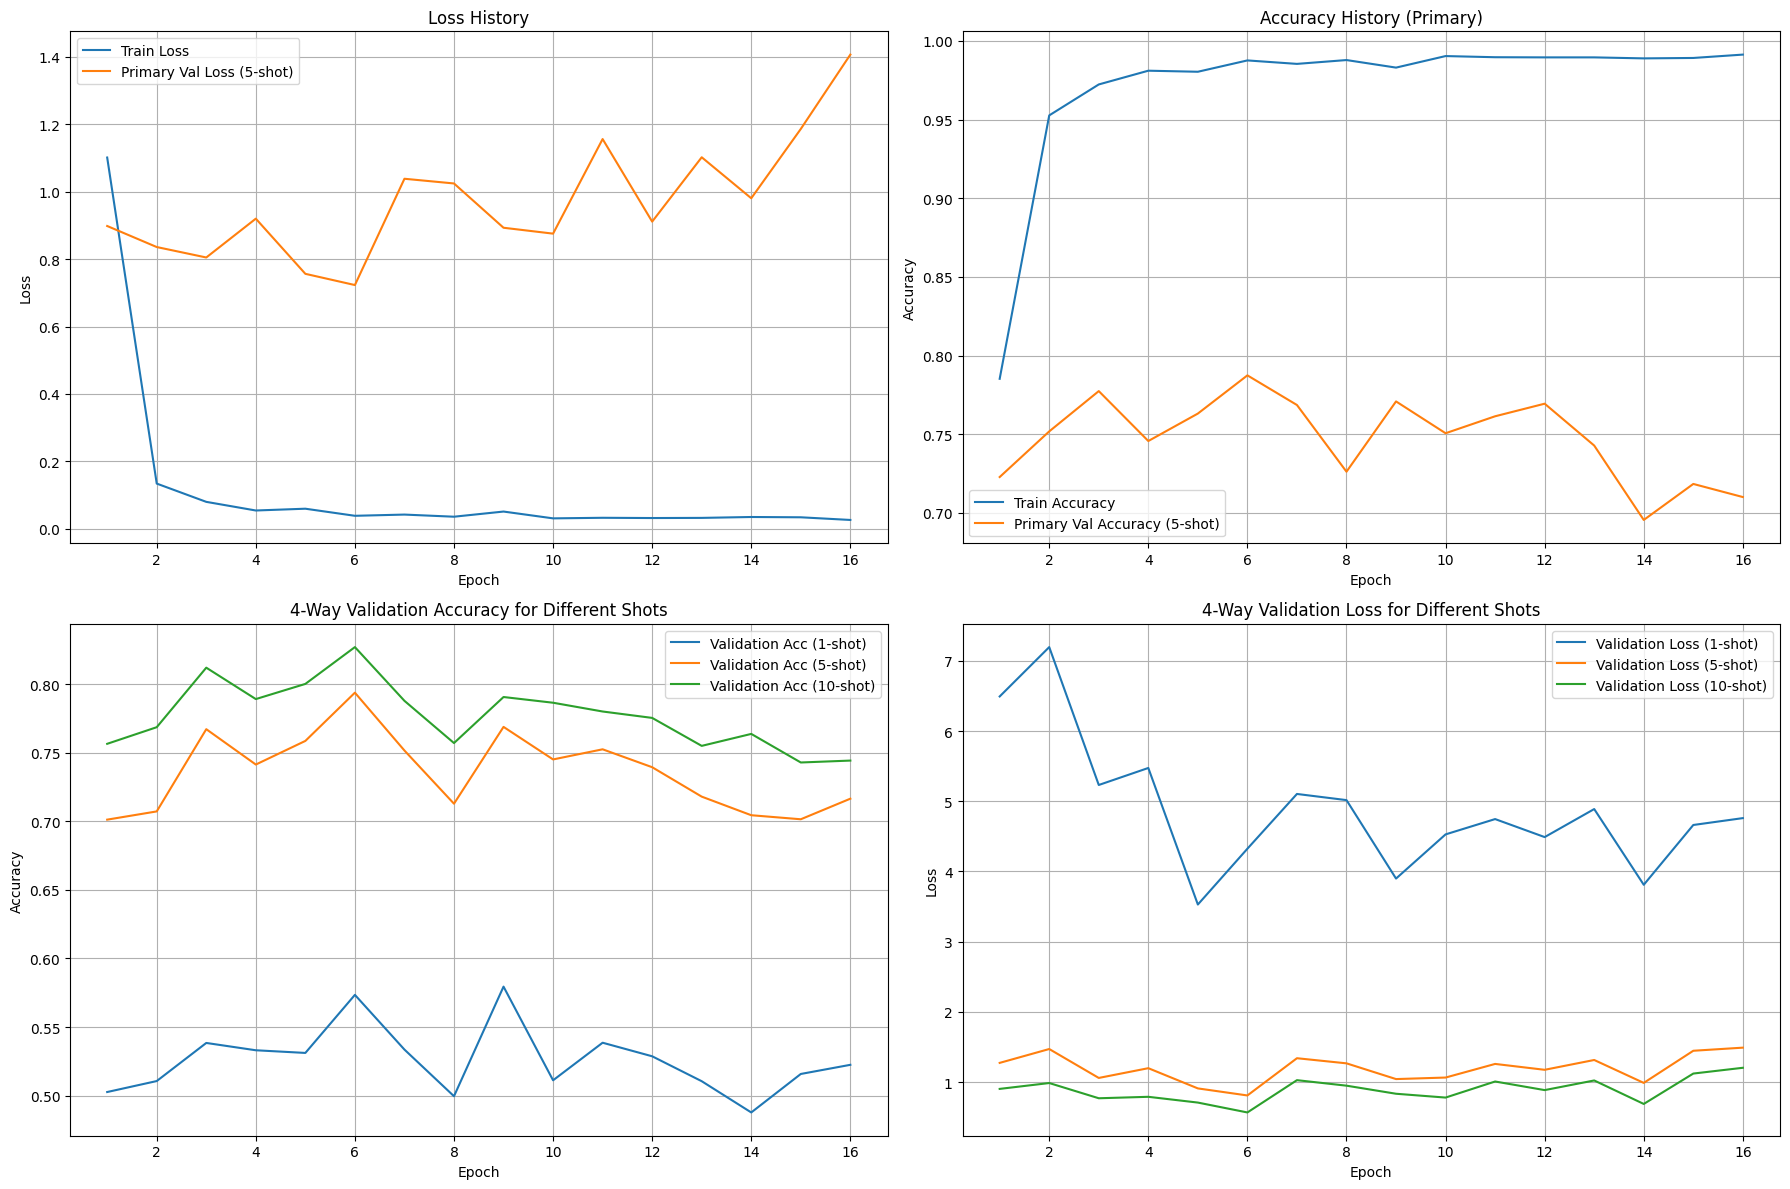

In [13]:
# --- Training Loop ---
print("\n--- Starting Training ---")
best_val_accuracy = 0.0 # Based on primary_val_loader
epochs_without_improvement = 0

train_losses_history, train_accs_history = [], []
primary_val_losses_history, primary_val_accs_history = [], []

# History for multi-shot validation
val_multi_shot_accs_history = {shot: [] for shot in VAL_EVAL_SHOTS}
val_multi_shot_loss_history = {shot: [] for shot in VAL_EVAL_SHOTS} # Also track loss if desired

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    # Train one epoch
    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses_history.append(train_loss)
    train_accs_history.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Evaluate on the primary validation set (e.g., 5-shot)
    # This is used for early stopping and saving the best model
    primary_val_loss, primary_val_accuracy = evaluate(model, primary_val_loader, criterion, device, 
                                                        description=f"Validating ({VAL_NUM_SUPPORT}-shot)")
    primary_val_losses_history.append(primary_val_loss)
    primary_val_accs_history.append(primary_val_accuracy)
    print(f"Primary Validation Loss ({VAL_NUM_SUPPORT}-shot): {primary_val_loss:.4f}, "
            f"Primary Validation Accuracy ({VAL_NUM_SUPPORT}-shot): {primary_val_accuracy:.4f}")

    # --- Multi-shot validation evaluation for plotting ---
    print("Performing multi-shot validation evaluation...")
    for shot in VAL_EVAL_SHOTS:
        # Create a specific dataset and loader for this shot configuration
        # Using 'test' split as per your setup for validation data
        current_shot_val_dataset = FewShotDataset(
            data_dir=data_dir,
            split='test', # Using 'test' path for validation data
            num_ways=VAL_NUM_WAYS,
            num_support=shot, # Current shot being evaluated
            num_query=VAL_NUM_QUERY,
            num_episodes=VAL_EPISODES, # Can adjust if this becomes too slow
            target_size=IMAGE_SIZE,
            use_grayscale=USE_GRAYSCALE,
            augment=False
        )
        if not current_shot_val_dataset.classes or len(current_shot_val_dataset.classes) < VAL_NUM_WAYS:
            print(f"  Skipping {shot}-shot validation: Insufficient classes/data in 'test' split for {VAL_NUM_WAYS}-way {shot}-shot.")
            val_multi_shot_accs_history[shot].append(0.0) # Append 0 or NaN if skipping
            val_multi_shot_loss_history[shot].append(float('nan'))
            continue

        current_shot_val_loader = get_data_loader(current_shot_val_dataset, shuffle=False)
        
        shot_val_loss, shot_val_accuracy = evaluate(model, current_shot_val_loader, criterion, device,
                                                    description=f"Validating ({shot}-shot)")
        
        val_multi_shot_accs_history[shot].append(shot_val_accuracy)
        val_multi_shot_loss_history[shot].append(shot_val_loss)
        print(f"  Validation ({VAL_NUM_WAYS}-way {shot}-shot) - Loss: {shot_val_loss:.4f}, Accuracy: {shot_val_accuracy:.4f}")

    # Check for improvement using the primary validation accuracy
    if primary_val_accuracy > best_val_accuracy:
        print(f"Primary Validation accuracy ({VAL_NUM_SUPPORT}-shot) improved ({best_val_accuracy:.4f} -> {primary_val_accuracy:.4f}). Saving model...")
        best_val_accuracy = primary_val_accuracy
        torch.save(model.state_dict(), best_model_path)
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        print(f"No improvement in primary validation accuracy for {epochs_without_improvement} epochs.")

    # Early stopping
    if epochs_without_improvement >= PATIENCE:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

print("\n--- Training Finished ---")

# --- Plotting training history ---
epochs_range = range(1, len(train_losses_history) + 1)

# Plot 1: Loss History (Train vs. Primary Validation)
plt.figure(figsize=(18, 12)) # Adjusted figure size for more plots

plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses_history, label='Train Loss')
plt.plot(epochs_range, primary_val_losses_history, label=f'Primary Val Loss ({VAL_NUM_SUPPORT}-shot)')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy History (Train vs. Primary Validation)
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accs_history, label='Train Accuracy')
plt.plot(epochs_range, primary_val_accs_history, label=f'Primary Val Accuracy ({VAL_NUM_SUPPORT}-shot)')
plt.title('Accuracy History (Primary)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot 3: Multi-Shot Validation Accuracy History
plt.subplot(2, 2, 3)
for shot in VAL_EVAL_SHOTS:
    # Ensure the history list has the same length as epochs_range
    # This handles cases where training might have stopped early
    acc_history = val_multi_shot_accs_history[shot]
    if len(acc_history) < len(epochs_range):
        # Pad with the last known value or NaN if you prefer
        acc_history.extend([acc_history[-1] if acc_history else 0.0] * (len(epochs_range) - len(acc_history)))

    plt.plot(epochs_range, acc_history, label=f'Validation Acc ({shot}-shot)')
plt.title(f'{VAL_NUM_WAYS}-Way Validation Accuracy for Different Shots')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot 4: Multi-Shot Validation Loss History (Optional)
plt.subplot(2, 2, 4)
for shot in VAL_EVAL_SHOTS:
    loss_history = val_multi_shot_loss_history[shot]
    if len(loss_history) < len(epochs_range):
        loss_history.extend([loss_history[-1] if loss_history else float('nan')] * (len(epochs_range) - len(loss_history)))

    plt.plot(epochs_range, loss_history, label=f'Validation Loss ({shot}-shot)')
plt.title(f'{VAL_NUM_WAYS}-Way Validation Loss for Different Shots')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plot_path = os.path.join(output_dir, 'training_history_detailed.png')
plt.savefig(plot_path)
print(f"Detailed training history plot saved to {plot_path}")
plt.show() # You had this, so keeping it.

In [14]:
# --- Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set ---")
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}")
    model.load_state_dict(torch.load(best_model_path, map_location=device))
else:
    print("Warning: No best model found. Evaluating with the last model state.")

test_results_summary = {}
for num_shots_test in TEST_NUM_SHOTS:  # Renamed to avoid conflict with 'shot' in VAL_EVAL_SHOTS loop
    print(f"\n--- Evaluating {TEST_NUM_WAYS}-way {num_shots_test}-shot on Test Set ---")
    test_dataset = FewShotDataset(
        data_dir=data_dir,
        split='test',
        num_ways=TEST_NUM_WAYS,
        num_support=num_shots_test,
        num_query=TEST_NUM_QUERY,
        num_episodes=TEST_EPISODES,
        target_size=IMAGE_SIZE,
        use_grayscale=USE_GRAYSCALE,
        augment=False
    )
    if not test_dataset.classes or len(test_dataset.classes) < TEST_NUM_WAYS:
        print(f"  Skipping {num_shots_test}-shot test evaluation: Insufficient classes/data in 'test' split for {TEST_NUM_WAYS}-way {num_shots_test}-shot.")
        test_results_summary[f"{num_shots_test}-shot"] = {"loss": float('nan'), "accuracy": 0.0, "variance": 0.0, "std": 0.0}
        continue

    test_loader = get_data_loader(test_dataset, shuffle=False)
    print(f"  Test dataset ({num_shots_test}-shot): {len(test_dataset.classes)} classes found.")

    test_loss, test_accuracy, test_variance, test_std = evaluate_with_std(
        model, test_loader, criterion, device, description=f"Testing {num_shots_test}-shot"
    )
    print(f"  Test Results ({num_shots_test}-shot):")
    print(f"    Loss: {test_loss:.4f}")
    print(f"    Accuracy: {test_accuracy:.4f} ± {test_std:.4f} (Variance: {test_variance:.6f})")
    test_results_summary[f"{num_shots_test}-shot"] = {
        "loss": test_loss,
        "accuracy": test_accuracy,
        "variance": test_variance,
        "std": test_std
    }

print("\n--- Final Test Summary ---")
for shot_setting, metrics in test_results_summary.items():
    print(f"  {shot_setting}: Accuracy = {metrics['accuracy']:.4f} ± {metrics['std']:.4f}, Loss = {metrics['loss']:.4f}, Variance = {metrics['variance']:.6f}")

print("\n--- Evaluation Complete ---")


--- Evaluating on Test Set ---
Loading best model from /home/ifihan/multi-dease-detection/results/best_protonet_model.pth

--- Evaluating 4-way 1-shot on Test Set ---
  Test dataset (1-shot): 4 classes found.


  Test Results (1-shot):
    Loss: 4.1782
    Accuracy: 0.5700 ± 0.1070 (Variance: 0.011441)

--- Evaluating 4-way 5-shot on Test Set ---
  Test dataset (5-shot): 4 classes found.


  Test Results (5-shot):
    Loss: 0.8463
    Accuracy: 0.7860 ± 0.0534 (Variance: 0.002856)

--- Evaluating 4-way 10-shot on Test Set ---
  Test dataset (10-shot): 4 classes found.


  Test Results (10-shot):
    Loss: 0.5561
    Accuracy: 0.8307 ± 0.0423 (Variance: 0.001790)

--- Final Test Summary ---
  1-shot: Accuracy = 0.5700 ± 0.1070, Loss = 4.1782, Variance = 0.011441
  5-shot: Accuracy = 0.7860 ± 0.0534, Loss = 0.8463, Variance = 0.002856
  10-shot: Accuracy = 0.8307 ± 0.0423, Loss = 0.5561, Variance = 0.001790

--- Evaluation Complete ---
